# Automated Visual Pollution Classification


In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# import zipfile
# Unzip the downloaded file
# zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/dataset.zip", "r")
# zip_ref.extractall()
# zip_ref.close()

In [3]:
# Importing required Packages
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pickle
import os
from skimage.io import imread as sk_imread, imshow as sk_imshow
from sklearn.model_selection import train_test_split

In [4]:
DATA_DIR = 'dataset'
df = pd.read_csv('dataset/train.csv')
# adding absolute path
df['image_path'] = "dataset/images/"+df['image_path']
df.head()

,class,image_path,name,xmax,xmin,ymax,ymin
0,3.0,dataset/images/4a48c42c9579ec0399e6c5a3e825e76...,GARBAGE,797.0,701.0,262.0,211.0
1,3.0,dataset/images/4a48c42c9579ec0399e6c5a3e825e76...,GARBAGE,932.0,786.0,329.0,238.0
2,3.0,dataset/images/4a48c42c9579ec0399e6c5a3e825e76...,GARBAGE,736.0,657.0,275.0,229.0
3,7.0,dataset/images/ea906a663da6321bcef78be4b7d1aff...,BAD_BILLBOARD,986.0,786.0,136.0,0.0
4,8.0,dataset/images/1c7d48005a12d1b19261b8e71df7caf...,SAND_ON_ROAD,667.0,549.0,228.0,179.0


In [5]:
print(f"Dataframe shape is: {df.shape}")
print(f"Dataframe length is: {len(df)}")

Dataframe shape is: (19950, 7)
Dataframe length is: 19950


In [6]:
def get_ds_info():
    '''
    helper function to count images in our dataset
    '''
    image_count = 0
    for root,dir,files in os.walk('dataset/images'):
        image_count = len(files) 
    return image_count

count_images = get_ds_info()
count_images

9966

In [7]:
# Total class names(unique)
class_names = df.groupby('class')['name'].apply(lambda x: np.unique(x))
class_names

class
0.0              [GRAFFITI]
1.0         [FADED_SIGNAGE]
2.0              [POTHOLES]
3.0               [GARBAGE]
4.0     [CONSTRUCTION_ROAD]
5.0        [BROKEN_SIGNAGE]
6.0       [BAD_STREETLIGHT]
7.0         [BAD_BILLBOARD]
8.0          [SAND_ON_ROAD]
9.0      [CLUTTER_SIDEWALK]
10.0        [UNKEPT_FACADE]
Name: name, dtype: object

#### Total images: 9966 rows
#### Total length of train.csv - 19950
- in training file there are 19950 image_path where an image_path is duplicating but with different cordinates.
### conclusion
- We have total 9966 images in our dataset
- in training file total 19950 images with duplicates.
- total uniquly identify : 7874 + 12076 = 19950
- in testing file 2092 images.
- total images : 7874 + 2092 = 9966

In [8]:
def view_random_image(img_path,label):
    '''
    Read images using sk_imread and plot images.
    '''
    image = sk_imread(img_path)
    plt.imshow(image)
    plt.title(label)
    plt.axis(False)
    return image

Shape of image: (1080, 1920, 3)
Type of image <class 'numpy.ndarray'>


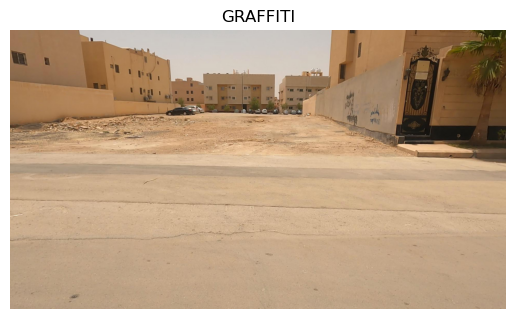

In [9]:
# for random index
ind = np.random.randint(0, 500)
# image reading using scikit image
image = view_random_image(df['image_path'].iloc[ind],df['name'].iloc[ind])
print('Shape of image:', image.shape)
print('Type of image', type(image))

- Images shape : (1080,1920,3)
- width : 1920
- height : 1080
- channel : 3 (RGB)

In [10]:
sample_img = df[['xmax','xmin','ymax','ymin']].iloc[:3]
sample_img

,xmax,xmin,ymax,ymin
0,797.0,701.0,262.0,211.0
1,932.0,786.0,329.0,238.0
2,736.0,657.0,275.0,229.0


Text(0.5, 1.0, 'GARBAGE')

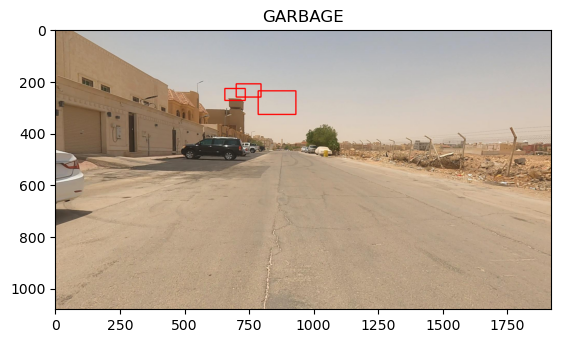

In [11]:
img = sk_imread(df['image_path'].iloc[0])
for i,row in sample_img.iterrows():
    cv2.rectangle(img, (int(row['xmax']),int(row['ymax'])), (int(row['xmin']), int(row['ymin'])), (255, 0, 0), 4)
plt.imshow(img)
plt.title(df['name'].iloc[0])

### training and validation split


In [12]:
train_df,val_df = train_test_split(df,test_size=0.1,random_state=123,shuffle=True)
train_df.shape,val_df.shape
train_df.head(5)

,class,image_path,name,xmax,xmin,ymax,ymin
827,9.0,dataset/images/e3f24cd8f5eed952a77c3fb88b7600b...,CLUTTER_SIDEWALK,212.0,13.0,284.0,203.0
17779,9.0,dataset/images/a43ad666c3c2497ecf462971d77463b...,CLUTTER_SIDEWALK,143.0,-30.0,328.0,237.0
9501,1.0,dataset/images/35df260224baa507a0b3e5e98169506...,FADED_SIGNAGE,801.0,706.0,371.0,146.0
15797,3.0,dataset/images/98505e19dc284a1f1955c62150d4d59...,GARBAGE,950.0,846.0,227.0,178.0
13789,3.0,dataset/images/d3af748e17839986022ab6c4c1ac1cc...,GARBAGE,800.0,728.0,367.0,316.0


In [13]:
image_paths = train_df['image_path'].tolist()
class_lables = train_df['class'].values
bbox = train_df[['xmin','xmax','ymin','ymax']].values

In [14]:
def preprocess_img(image,label):
    image = tf.image.decode_jpeg(image, channels=3)
    (cls,bbox) = label
    width = tf.cast(tf.shape(image)[1], tf.float64)
    height = tf.cast(tf.shape(image)[0], tf.float64)
    bbox = tf.stack([bbox[0]/width, bbox[1]/width, bbox[2]/height, bbox[3]/height], axis=-1)
    image = tf.image.resize(image, (224, 224))
    image /= 255.0
    return image,(cls,bbox)

def load_and_preprocess_image(path,label):
    image = tf.io.read_file(path)
    return preprocess_img(image,label)
  

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_ds = tf.data.Dataset.from_tensor_slices((image_paths,(class_lables,bbox)))
train_ds = train_ds.map(load_and_preprocess_image,num_parallel_calls=tf.data.AUTOTUNE)
train_ds
val_image_paths = val_df['image_path'].tolist()
val_class_lables = val_df['class'].values
val_bbox = val_df[['xmin','xmax','ymin','ymax']].values
val_ds = tf.data.Dataset.from_tensor_slices((val_image_paths,(val_class_lables,val_bbox)))
val_ds = val_ds.map(load_and_preprocess_image,num_parallel_calls=tf.data.AUTOTUNE)
len(train_ds),len(val_ds)


(17955, 1995)

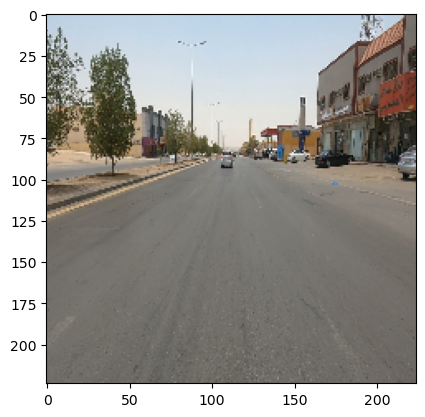

In [16]:
for image,l in train_ds.take(1):
  plt.imshow(image)

In [17]:
train_ds = train_ds.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
train_ds,val_ds

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.float64, name=None), TensorSpec(shape=(None, 4), dtype=tf.float64, name=None)))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.float64, name=None), TensorSpec(shape=(None, 4), dtype=tf.float64, name=None)))>)

In [18]:
base_model = tf.keras.applications.efficientnet.EfficientNetB2(
      input_shape=(224,224, 3), include_top=False, 
      weights='imagenet'
  )
  # Add a new top layer for classification
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
class_output = tf.keras.layers.Dense(11, activation='softmax', name='class')(x)

  # Add a new top layer for bounding box regression
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
bbox_output = tf.keras.layers.Dense(4, activation='linear', name='bbox')(x)

  # Create a new model with the new top layers
model = tf.keras.models.Model(inputs=base_model.input, outputs=[class_output, bbox_output])
initial_learning_rate = 1e-4

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),loss={
      'class':'sparse_categorical_crossentropy',
      'bbox':'mean_squared_error'
  },
metrics={
      'class':'accuracy',
      'bbox':'mae'
},
loss_weights=[1, 5])
log_dir = 'logs/' + 'effnet'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, verbose=2)
checkpointer = tf.keras.callbacks.ModelCheckpoint('models/Effnet/model.h5', save_best_only=True ,verbose=1)
  # model.summary()



31790344/31790344 [==============================] - 5s 0us/step


In [19]:
model.fit(train_ds,epochs=5,validation_data=val_ds,batch_size=32,verbose=1, callbacks = [tensorboard_callback, checkpointer])

Epoch 1/5


KeyboardInterrupt: 

In [ ]:
acc = model.evaluate(val_ds)
print('Test accuracy:', acc)

63/63 [==============================] - 15s 235ms/step - loss: 429.0624 - class_loss: 25.8995 - bbox_loss: 80.6326 - class_accuracy: 0.4085 - bbox_mae: 2.4036
Test accuracy: [429.0623779296875, 25.89952850341797, 80.63258361816406, 0.40852129459381104, 2.4036498069763184]


In [ ]:
predictions = model.predict(val_ds)


63/63 [==============================] - 17s 217ms/step


In [20]:
new_model = tf.keras.models.load_model('models/model.h5')

1/1 [==============================] - 0s 326ms/step
['GARBAGE'] [[0.12270701 0.23057345 0.1932439  0.43176964]]


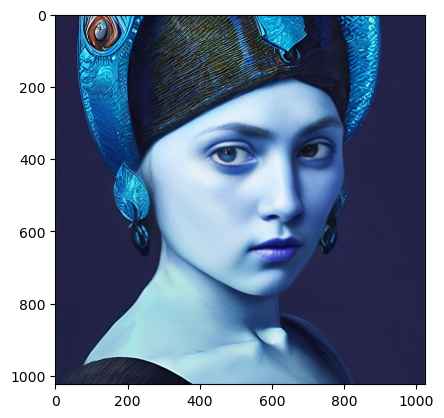

In [34]:
import urllib.request
from PIL import Image
test_df = pd.read_csv('dataset/test.csv')
img_path  = urllib.request.urlretrieve("https://replicate.delivery/mgxm/85f53415-0dc7-4703-891f-1e6f912119ad/output.png",'yash.png')
# img_path = 'dataset/images/' + test_df['image_path'].iloc[1]
img = cv2.imread('yash.png')
plt.imshow(img)
img = tf.image.resize(img, (224, 224))
img = img / 255.0
img = np.expand_dims(img,axis=0)
pred = new_model.predict(img)
class_name = class_names[np.argmax(pred[0])]
bbox = pred[1]
print(class_name,bbox)

In [ ]:
test_df = pd.read_csv('dataset/test.csv')
predictions = []
for i, row in test_df.iterrows():
    # Load the image
    image_path = 'dataset/images/' + row['image_path']
    image = cv2.imread(image_path)
    image = tf.image.resize(img, (224, 224))
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    # Create a blob from the image
    pred = new_model.predict(image)
    class_name = class_names[np.argmax(pred[0])]
    bbox = pred[1]
    # Interpret the model's output to obtain the predicted labels, classes, and bounding boxes
    # ...

    # Append the predictions to the list
    predictions.append({'img_path': row['image_path'], 'class': class_name, 'bounding_box': bbox})

# Append the predictions to the test dataframe
# test_df['label'] = [p['label'] for p in predictions]
# test_df['class'] = [p['class'] for p in predictions]
# test_df['bounding_box'] = [p['bounding_box'] for p in predictions]

# Write the updated test dataframe to the test.csv file
# test_df.to_csv('test.csv', index=False)



1/1 [==============================] - 0s 26ms/step


In [ ]:
predictions[0]

{'img_path': '953ab1447c46ecfef67ab14629cd70c7.jpg',
 'class': array(['GARBAGE'], dtype=object),
 'bounding_box': array([[0.16749728, 0.4610478 , 0.12308387, 0.34765032]], dtype=float32)}

In [ ]:
test_df['image_path'] = [p['img_path'] for p in predictions]
test_df['class'] = [p['class'] for p in predictions]
test_df['bounding_box'] = [p['bounding_box'] for p in predictions]

# Write the updated test dataframe to the test.csv file
test_df.to_csv('test.csv', index=False)


In [ ]:
testcsv = pd.read_csv('test.csv')

In [ ]:
testcsv.head()

,image_path,class,bounding_box
0,953ab1447c46ecfef67ab14629cd70c7.jpg,['GARBAGE'],[[0.16749728 0.4610478 0.12308387 0.34765032]]
1,e4ddbaa7970fca225a51288ce5f7d3f9.jpg,['GARBAGE'],[[0.16749728 0.4610478 0.12308387 0.34765032]]
2,5b8120d69607a077b7583334be3ba18b.jpg,['GARBAGE'],[[0.16749728 0.4610478 0.12308387 0.34765032]]
3,138b1dc82005b4c33e4886260649d313.jpg,['GARBAGE'],[[0.16749728 0.4610478 0.12308387 0.34765032]]
4,0f91ec1533b845b13089f8cf4e0a36f7.jpg,['GARBAGE'],[[0.16749728 0.4610478 0.12308387 0.34765032]]


In [ ]:
new_model = tf.keras.models.load_model('models/model.h5')

